* Produce full-sized files
* MRMS has np.nan: MRMS is missing
* LDM_pred has np.nan: all-zero or MRMS is missing

In [1]:
import os
import sys
import time
import h5py

import numpy as np
from glob import glob

from datetime import datetime, timedelta

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_01 = h5io['lon_01'][...]
    lat_01 = h5io['lat_01'][...]
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]    

In [5]:
# data size info
x_mrms = 256; y_mrms = 576 # 0.1 deg MRMS size
x_gfs = 105; y_gfs = 242 # 0.25 deg GFS size

N_days = 300
N_ens = 10

Nx_pred = 2
Ny_pred = 5
Ny_gap = 12
size_pred = 128

LEADs = [3,]

In [7]:
name = '/glade/campaign/cisl/aiml/ksha/LDM_results/LDM_day{:03d}_ini{:02d}_lead{:02d}.npy'
save_name = 'LDM_2023_ini{:02d}_lead{:02d}.hdf'

In [8]:
ini = 0

for lead in LEADs:

    MRMS_PRED = np.empty((N_days, N_ens, x_mrms, y_mrms)); MRMS_PRED[...] = np.nan
    MRMS_TRUE = np.empty((N_days, x_mrms, y_mrms)); MRMS_TRUE[...] = np.nan
    APCP_TRUE = np.empty((N_days, x_mrms, y_mrms)); APCP_TRUE[...] = np.nan
    
    MRMS_pred_domain = np.empty((N_ens, x_mrms, y_mrms)); MRMS_pred_domain[...] = np.nan
    MRMS_true_domain = np.empty((x_mrms, y_mrms)); MRMS_true_domain[...] = np.nan
    APCP_true_domain = np.empty((x_mrms, y_mrms)); APCP_true_domain[...] = np.nan
    
    for day in range(N_days):
        name_ = name.format(day, ini, lead)
        
        if os.path.isfile(name_):
            temp_data = np.load(name_, allow_pickle=True)[()]
            MRMS_pred = np.exp(temp_data['MRMS_pred']) - 1
            MRMS_true = np.exp(temp_data['MRMS_true']) - 1
            APCP_true = np.exp(temp_data['APCP_true']) - 1
        
            count = 0
            for px in range(Nx_pred):
                for py in range(Ny_pred):
                    ix0 = size_pred*px
                    ix1 = ix0+size_pred
                    
                    if py < (Ny_pred-1):
                        iy0 = (size_pred-Ny_gap)*py
                        iy1 = iy0 + size_pred
                    else:
                        iy1 = y_mrms
                        iy0 = y_mrms - size_pred
            
                    MRMS_pred_domain[:, ix0:ix1, iy0:iy1] = MRMS_pred[:, count, :, :]
                    MRMS_true_domain[ix0:ix1, iy0:iy1] = MRMS_true[count, :, :]
                    APCP_true_domain[ix0:ix1, iy0:iy1] = APCP_true[count, :, :]
                    count += 1
                    
            MRMS_pred_domain[np.isnan(MRMS_pred_domain)] = 0
            MRMS_pred_domain[MRMS_pred_domain<0] = 0
        
            MRMS_PRED[day, ...] = MRMS_pred_domain
            MRMS_TRUE[day, ...] = MRMS_true_domain
            APCP_TRUE[day, ...] = APCP_true_domain
        
        else:
            print('missing: {}'.format(name_))
    
    
    # save_name_ = save_name.format(ini, lead)
    # print(save_name_)
    # tuple_save = (MRMS_PRED, MRMS_TRUE, APCP_TRUE)
    # label_save = ['MRMS_PRED', 'MRMS_TRUE', 'APCP_TRUE']
    # du.save_hdf5(tuple_save, label_save, '/glade/campaign/cisl/aiml/ksha/LDM_results/', save_name_)

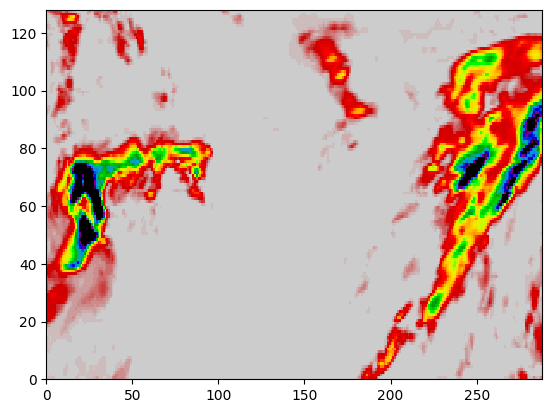

In [24]:
plt.pcolormesh(APCP_TRUE[0, ::2, ::2], vmin=0, vmax=10, cmap=plt.cm.nipy_spectral_r)

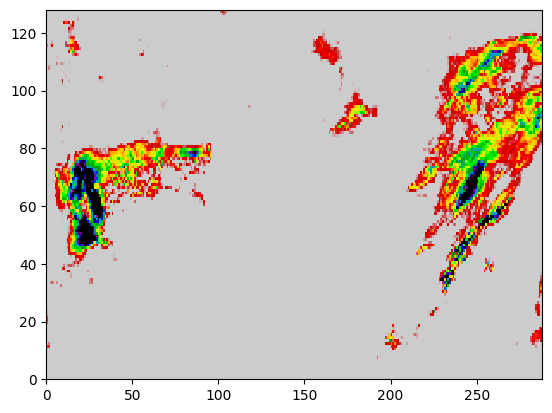

In [25]:
plt.pcolormesh(MRMS_TRUE[0, ::2, ::2], vmin=0, vmax=10, cmap=plt.cm.nipy_spectral_r)

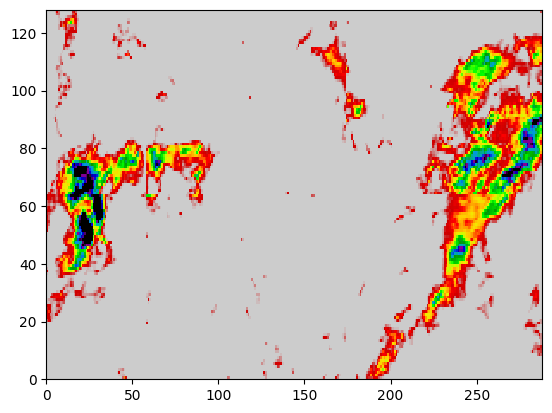

In [31]:
plt.pcolormesh(MRMS_PRED[0, 2, ::2, ::2], vmin=0, vmax=10, cmap=plt.cm.nipy_spectral_r)

In [24]:
with h5py.File('/glade/campaign/cisl/aiml/ksha/LDM_results/LDM_2023_ini00_lead12.hdf', 'r') as h5io:
    MRMS_TRUE = h5io['MRMS_TRUE'][...]

In [25]:
np.sum(np.isnan(MRMS_TRUE))

589824

In [26]:
np.sum(np.isnan(MRMS_PRED))

442368000